## Transform Video Data

### Imports

In [14]:
import polars as pl
import re
import textwrap
import matplotlib.pyplot as plt

### Load Data

In [33]:
df = pl.read_parquet('data/video-transcripts.parquet')

In [34]:
df.head()

video_id,datetime,title,transcript
str,str,str,str
"""qPN_XZcJf_s""","""2025-05-05T04:01:03Z""","""Reinforcement Learning with Hu…","""If you tell me what you like a…"
"""DVGmsnxB2UQ""","""2025-04-14T04:00:27Z""","""Reinforcement Learning with Ne…","""if you make a guess and you ma…"
"""9hbQieQh7-o""","""2025-04-07T04:00:17Z""","""Reinforcement Learning with Ne…","""When you don't know, take a gu…"
"""Z-T0iJEXiwM""","""2025-03-31T04:00:25Z""","""Reinforcement Learning: Essent…","""reinforcement learning it's ju…"
"""_kstkMF-lQQ""","""2025-02-12T14:20:19Z""","""StatQuest on DeepLearning.AI!!…","""the encoder model was used as …"


### EDA

#### Sizes

In [35]:
# shape + unique values
print("shape:", df.shape)
print("n unique rows:", df.n_unique())
for j in range(df.shape[1]):
    print("n unique elements (" + df.columns[j] + "):", df[:,j].n_unique())

shape: (269, 4)
n unique rows: 269
n unique elements (video_id): 269
n unique elements (datetime): 267
n unique elements (title): 265
n unique elements (transcript): 241


In [36]:
print("Total number of title characters:", sum(len(df['title'][i]) for i in range(len(df))))
print("Total number of transcript characters:", sum(len(df['transcript'][i]) for i in range(len(df))))

Total number of title characters: 11083
Total number of transcript characters: 2960389


#### Data Types

In [37]:
# change datetime to Datetime dtype
df = df.with_columns(pl.col('datetime').cast(pl.Datetime))
print(df.head())

shape: (5, 4)
┌─────────────┬─────────────────────┬───────────────────────────────┬──────────────────────────────┐
│ video_id    ┆ datetime            ┆ title                         ┆ transcript                   │
│ ---         ┆ ---                 ┆ ---                           ┆ ---                          │
│ str         ┆ datetime[μs]        ┆ str                           ┆ str                          │
╞═════════════╪═════════════════════╪═══════════════════════════════╪══════════════════════════════╡
│ qPN_XZcJf_s ┆ 2025-05-05 04:01:03 ┆ Reinforcement Learning with   ┆ If you tell me what you like │
│             ┆                     ┆ Hu…                           ┆ a…                           │
│ DVGmsnxB2UQ ┆ 2025-04-14 04:00:27 ┆ Reinforcement Learning with   ┆ if you make a guess and you  │
│             ┆                     ┆ Ne…                           ┆ ma…                          │
│ 9hbQieQh7-o ┆ 2025-04-07 04:00:17 ┆ Reinforcement Learning with   ┆ When yo

#### Character Lengths

(array([21., 25., 36., 63., 56., 32., 24.,  7.,  3.,  2.]),
 array([  4. ,  13.6,  23.2,  32.8,  42.4,  52. ,  61.6,  71.2,  80.8,
         90.4, 100. ]),
 <BarContainer object of 10 artists>)

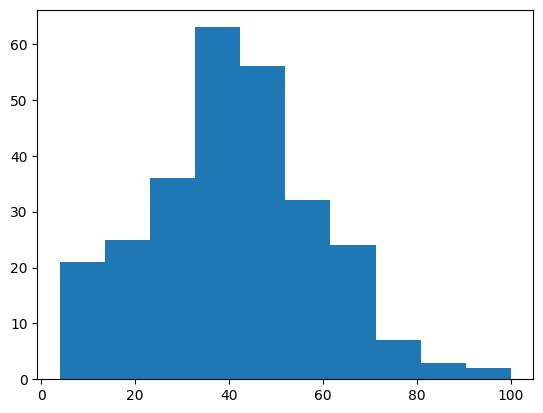

In [38]:
# lengths/character counts
plt.hist(df['title'].str.len_chars())

(array([101.,  65.,  47.,  17.,  16.,  12.,   2.,   2.,   1.,   6.]),
 array([3.00000e+00, 5.64770e+03, 1.12924e+04, 1.69371e+04, 2.25818e+04,
        2.82265e+04, 3.38712e+04, 3.95159e+04, 4.51606e+04, 5.08053e+04,
        5.64500e+04]),
 <BarContainer object of 10 artists>)

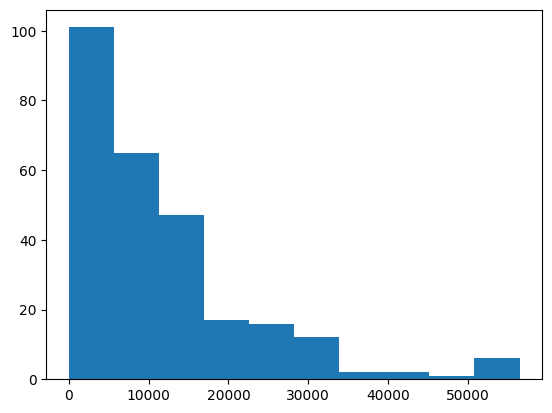

In [39]:
plt.hist(df['transcript'].str.len_chars())

### Preprocessing

#### Handling Special Strings

In [40]:
# matches anything that is NOT a word character or whitespace
special_char_pattern = r"[^\w\s]" 

In [41]:
# Extract indices where special characters are found in 'transcript'
matching_indices = [
    idx for idx, text in enumerate(df["transcript"])
    if re.search(special_char_pattern, text)
]

In [42]:
print("Special characters found in rows:", matching_indices)

Special characters found in rows: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 39, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

In [43]:
for idx, title in enumerate(df['title']):
    print(f"Row {idx}: Title: {title}")

Row 0: Title: Reinforcement Learning with Human Feedback (RLHF), Clearly Explained!!!
Row 1: Title: Reinforcement Learning with Neural Networks: Mathematical Details
Row 2: Title: Reinforcement Learning with Neural Networks: Essential Concepts
Row 3: Title: Reinforcement Learning: Essential Concepts
Row 4: Title: StatQuest on DeepLearning.AI!!! Check out my short course on attention!
Row 5: Title: StatQuest with Josh Starmer is live!
Row 6: Title: Luis Serrano + Josh  Starmer Q&amp;A Livestream!!!
Row 7: Title: Human Stories in AI: Nana Janashia@TechWorld With Nana
Row 8: Title: A few more lessons from my Pop!
Row 9: Title: Human Stories in AI: Abbas Merchant@Matics Analytics
Row 10: Title: Luis Serrano + Jay Alammar + Josh  Starmer Q&amp;A Livestream!!!
Row 11: Title: Coding a ChatGPT Like Transformer From Scratch in PyTorch
Row 12: Title: Human Stories in AI: Amy Finnegan
Row 13: Title: Human Stories in AI: Xavier Moyá
Row 14: Title: Human Stories in AI: Tommy Tang
Row 15: Title: Lui

In [44]:
# Wrapped title and transcript
print("Title:\n" + textwrap.fill(df['title'][6], width=80))
print("\nTranscript:\n" + textwrap.fill(df['transcript'][6], width=80))

Title:
Luis Serrano + Josh  Starmer Q&amp;A Livestream!!!

Transcript:
hooray so it says we're live hello I'm G to chat hello hello everyone it says I
don't see us oh yeah there we are all right do you see us on the on the I think
we're yeah I think we're live okay and we have a few people hi everybody hello
it takes a few minutes to get things rolling technology I see some people saying
hi Jan gumar Adriana Rolf and we had a few technical difficulties getting the
live stream connected so I'm like is it actually working I don't know but it
looks like it is I I'm seeing some stuff in the chat that suggest it is working
it worked out I'm very happy to hear that yeah yeah cool so how are you doing
Josh I'm doing great how are you doing you just got back from a vacation yeah
yeah it was fun I was in Europe for a bit and you got back from some interesting
trips right yeah I was in uh I uh I guess the last time we did the live stream
was in July uh so it's been a while so I've J what's that 

In [45]:
special_strings = ['&#39;', '&amp;']
special_string_replacements = ["'", "&"]

# Start with current title and transcript
title_col = df['title']
transcript_col = df['transcript']

# Loop through replacements and apply them
for target, replacement in zip(special_strings, special_string_replacements):
    title_col = title_col.str.replace(target, replacement)
    transcript_col = transcript_col.str.replace(target, replacement)

In [46]:
# Update the DataFrame with cleaned columns
df= df.with_columns([
    title_col.alias('title'),
    transcript_col.alias('transcript')
])

In [47]:
for idx, title in enumerate(df['title']):
    print(f"Row {idx}: Title: {title}")

Row 0: Title: Reinforcement Learning with Human Feedback (RLHF), Clearly Explained!!!
Row 1: Title: Reinforcement Learning with Neural Networks: Mathematical Details
Row 2: Title: Reinforcement Learning with Neural Networks: Essential Concepts
Row 3: Title: Reinforcement Learning: Essential Concepts
Row 4: Title: StatQuest on DeepLearning.AI!!! Check out my short course on attention!
Row 5: Title: StatQuest with Josh Starmer is live!
Row 6: Title: Luis Serrano + Josh  Starmer Q&A Livestream!!!
Row 7: Title: Human Stories in AI: Nana Janashia@TechWorld With Nana
Row 8: Title: A few more lessons from my Pop!
Row 9: Title: Human Stories in AI: Abbas Merchant@Matics Analytics
Row 10: Title: Luis Serrano + Jay Alammar + Josh  Starmer Q&A Livestream!!!
Row 11: Title: Coding a ChatGPT Like Transformer From Scratch in PyTorch
Row 12: Title: Human Stories in AI: Amy Finnegan
Row 13: Title: Human Stories in AI: Xavier Moyá
Row 14: Title: Human Stories in AI: Tommy Tang
Row 15: Title: Luis Serran

### Export Data

In [48]:
# write data to file
df.write_parquet('data/video-transcripts.parquet')
df.write_csv('data/video-transcripts.csv')